In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import gc

# import preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# import models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# import train test split
from sklearn.model_selection import train_test_split
#from sklearn.inspection import permutation_importance

# read data
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

## read in files
dir = '/content/drive/MyDrive/DS440/Wildfire_Data/Data/'
cnx = sqlite3.connect(dir + 'Wildfire_data.sqlite') 
cursor = cnx.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='Fires';")
tables = cursor.fetchall()
Fires = pd.read_sql_query("SELECT * FROM 'Fires'", cnx).set_index('FOD_ID')
Fires.drop(columns=['FPA_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM','NWCG_REPORTING_AGENCY','NWCG_REPORTING_UNIT_ID',\
                    'NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','LOCAL_FIRE_REPORT_ID',\
                    'LOCAL_INCIDENT_ID','FIRE_CODE','FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID','ICS_209_PLUS_COMPLEX_JOIN_ID',\
                    'MTBS_ID','MTBS_FIRE_NAME','COMPLEX_NAME','DISCOVERY_TIME','OWNER_DESCR','NWCG_CAUSE_CLASSIFICATION',\
                    'NWCG_CAUSE_AGE_CATEGORY', 'FIRE_SIZE_CLASS', 'CONT_TIME','CONT_DATE'],inplace=True) #'FIRE_SIZE_CLASS',
gc.collect()
# combine data into one dataframe



Mounted at /content/drive


0

### Data Preprocessing (Gabe)

In [3]:
# extract month from discovery date
def get_first_element(date_list):
  return date_list[0]

Fires['DISCOVERY_DATE'] = Fires['DISCOVERY_DATE'].astype("string")
Fires['DISCOVERY_LIST'] = Fires['DISCOVERY_DATE'].str.split(pat='/')
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_LIST'].map(get_first_element)
Fires['DISCOVERY_MONTH'] = Fires['DISCOVERY_MONTH'].astype("int64")


# encode causes into integers
Fires['NWCG_GENERAL_CAUSE'] = Fires['NWCG_GENERAL_CAUSE'].astype("string")
cause_enc = LabelEncoder()
Fires['NWCG_CAUSE_CLASSIFICATION_ORD'] = cause_enc.fit_transform(Fires['NWCG_GENERAL_CAUSE'])


# figure out number of days to contain the fire
Fires['DAYS_TO_CONT'] = Fires['CONT_DOY'] - Fires['DISCOVERY_DOY']
##### if it was contained the next year, need to do something about that
def convert_negative_days(day):
  if day < 0:
    return 365 + day
  else:
    return day

Fires['DAYS_TO_CONT'] = Fires['DAYS_TO_CONT'].map(convert_negative_days)


# encode state categories into integers
Fires['STATE'] = Fires['STATE'].astype("string")
state_enc = LabelEncoder()
Fires['STATE_ORD'] = state_enc.fit_transform(Fires['STATE'])

# what to do about counties? Use fips code (must be an int)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("string")
Fires['FIPS_CODE'].fillna('1000000',inplace=True)
Fires['FIPS_CODE'] = Fires['FIPS_CODE'].astype("int64")

# fill NA with mean of day to containment (mean = 0.92)
Fires['DAYS_TO_CONT'].fillna(value=Fires['DAYS_TO_CONT'].mean(),inplace=True)


# drop date and list
Fires.drop(columns=['DISCOVERY_DATE','DISCOVERY_LIST','NWCG_GENERAL_CAUSE',\
                    'CONT_DOY','DISCOVERY_DOY','STATE','FIPS_NAME',\
                    'COUNTY'],inplace=True)
gc.collect()

32

In [ ]:
state_enc.classes_

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [ ]:
Fires

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
FOD_ID,,,,,,,,,
1,2005,0.10,40.036944,-121.005833,6063,2,9,0.000000,4
2,2004,0.25,38.933056,-120.404444,6061,5,7,0.000000,4
3,2004,0.10,38.984167,-120.735556,6017,5,1,0.000000,4
4,2004,0.10,38.559167,-119.913333,6003,6,7,5.000000,4
5,2004,0.10,38.559167,-119.933056,6003,6,7,5.000000,4
...,...,...,...,...,...,...,...,...,...
400482078,2016,125.00,36.431667,-84.421667,47151,10,5,0.923788,43
400482080,2016,120.00,31.143611,-88.111944,1129,10,5,0.923788,1
400482083,2017,120.00,33.920000,-85.310000,1029,4,5,0.923788,1


### EDA (Gabe and Colby)

(array([2.16669e+06, 5.20000e+01, 1.10000e+01]),
 array([1.000e-05, 2.209e+05, 4.418e+05, 6.627e+05]),
 <a list of 3 Patch objects>)

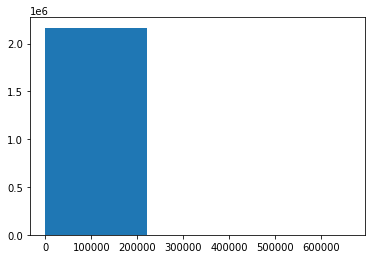

In [4]:
plt.hist(Fires['FIRE_SIZE'], density=False, bins=3)

(array([3.21080e+04, 4.68400e+04, 6.11675e+05, 7.58469e+05, 4.29648e+05,
        2.73888e+05, 6.00000e+00, 1.28300e+03, 1.05150e+04, 2.32100e+03]),
 array([17.93972222, 23.17881   , 28.41789778, 33.65698555, 38.89607333,
        44.13516111, 49.37424889, 54.61333667, 59.85242444, 65.09151222,
        70.3306    ]),
 <a list of 10 Patch objects>)

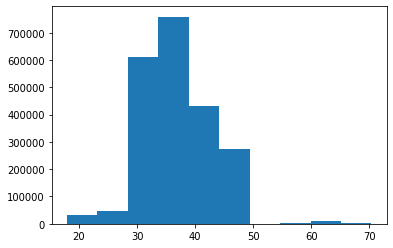

In [5]:
plt.hist(Fires['LATITUDE'], density=False, bins=10)

(array([6.00000e+00, 1.04670e+04, 1.17640e+04, 1.62700e+03, 8.31450e+04,
        4.40302e+05, 2.42508e+05, 5.09149e+05, 6.97258e+05, 1.70527e+05]),
 array([-178.8026    , -167.44803444, -156.09346889, -144.73890333,
        -133.38433778, -122.02977222, -110.67520666,  -99.32064111,
         -87.96607555,  -76.61151   ,  -65.25694444]),
 <a list of 10 Patch objects>)

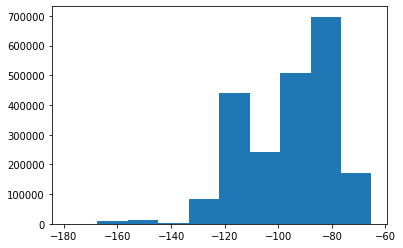

In [6]:
plt.hist(Fires['LONGITUDE'], density=False, bins=10)

In [7]:
np.histogram(Fires[Fires['FIRE_SIZE'] <= 2e+05]['FIRE_SIZE'])

(array([2165295,     743,     290,     138,      76,      41,      27,
             30,      23,      14]),
 array([1.000000e-05, 1.992880e+04, 3.985760e+04, 5.978640e+04,
        7.971520e+04, 9.964400e+04, 1.195728e+05, 1.395016e+05,
        1.594304e+05, 1.793592e+05, 1.992880e+05]))

(array([1027824.,  310697.,   59251.,  138733.,   24451.,   80514.,
          12070.,   45486.,    7720.,   68306.]),
 array([1.000000e-05, 5.000090e-01, 1.000008e+00, 1.500007e+00,
        2.000006e+00, 2.500005e+00, 3.000004e+00, 3.500003e+00,
        4.000002e+00, 4.500001e+00, 5.000000e+00]),
 <a list of 10 Patch objects>)

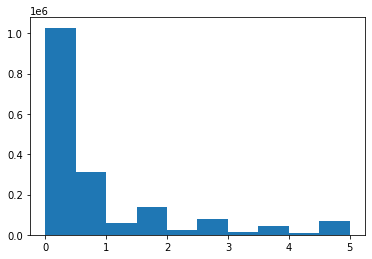

In [8]:
plt.hist(Fires[Fires['FIRE_SIZE'] <= 5]['FIRE_SIZE'])

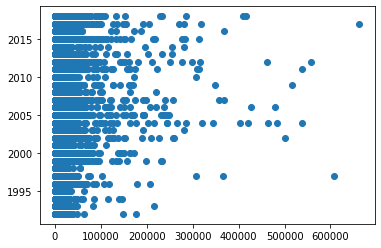

In [9]:
# Looking at Fire size compared to year
plt.scatter(Fires['FIRE_SIZE'], Fires['FIRE_YEAR'], marker='o');

(array([817539., 175824.,   2205.,  17205., 547438., 377437.,   9763.,
         28491.,  36437., 154414.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

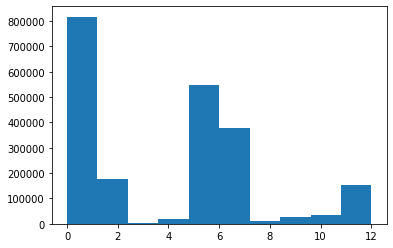

In [10]:
plt.hist(Fires['NWCG_CAUSE_CLASSIFICATION_ORD'], density=False, bins=10)

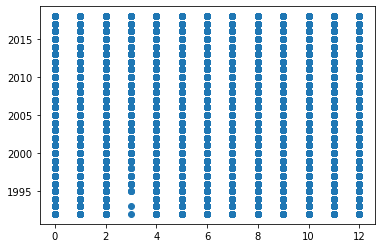

In [11]:
plt.scatter(Fires['NWCG_CAUSE_CLASSIFICATION_ORD'], Fires['FIRE_YEAR'], marker='o');

In [12]:
cause_enc.classes_

array(['Arson/incendiarism', 'Debris and open burning',
       'Equipment and vehicle use', 'Firearms and explosives use',
       'Fireworks', 'Missing data/not specified/undetermined',
       'Misuse of fire by a minor', 'Natural', 'Other causes',
       'Power generation/transmission/distribution',
       'Railroad operations and maintenance', 'Recreation and ceremony',
       'Smoking'], dtype=object)

### Created baseline MAE and MSE

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
FIRE_SIZE_PERMUTE = Fires['FIRE_SIZE'].sample(frac=1,random_state=0)

In [ ]:
print("MAE: ",mean_absolute_error(FIRE_SIZE_PERMUTE,Fires['FIRE_SIZE']))
print("MSE: ",mean_squared_error(FIRE_SIZE_PERMUTE,Fires['FIRE_SIZE']))

MAE:  149.40381504892986
MSE:  12867179.721882567


In [ ]:
Fires12 = Fires[Fires['FIRE_YEAR'] < 2013].copy()
Fires13 = Fires[Fires['FIRE_YEAR'] >= 2013].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

In [ ]:
X_train

,FIRE_YEAR,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
FOD_ID,,,,,,,,
1,2005,40.036944,-121.005833,6063,2,9,0.0,4
2,2004,38.933056,-120.404444,6061,5,7,0.0,4
3,2004,38.984167,-120.735556,6017,5,1,0.0,4
4,2004,38.559167,-119.913333,6003,6,7,5.0,4
5,2004,38.559167,-119.933056,6003,6,7,5.0,4
...,...,...,...,...,...,...,...,...
400443634,2012,33.485700,-112.148200,4013,3,5,0.0,3
400443635,2012,33.484100,-112.158900,4013,3,5,0.0,3
400443636,2012,33.453900,-112.087900,4013,3,5,0.0,3


### Initial Implementation

In [ ]:
Fires_sample = Fires.sample(frac=1)

In [ ]:
Fires_sample

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
FOD_ID,,,,,,,,,
19504938,2010,0.20,34.962783,-77.502450,37133,3,5,0.000000,27
1457762,2010,0.05,33.500451,-82.794310,13301,3,1,0.000000,10
201399347,2010,10.00,28.707753,-98.197174,48297,6,5,0.923788,44
1121811,2002,15.00,28.825800,-82.558600,12017,3,10,0.923788,9
1317621,1995,0.10,37.498889,-119.985000,1000000,7,2,0.923788,4
...,...,...,...,...,...,...,...,...,...
400355309,2018,25.00,37.458649,-83.449547,21025,4,0,1.000000,17
400133913,2017,0.10,35.250588,-120.622893,6079,9,1,0.923788,4
1805854,1993,0.10,37.937698,-82.420230,54099,1,0,0.000000,50


In [ ]:
Train_Fires = Fires_sample[Fires_sample['FIRE_YEAR'] < 2013].copy()

In [ ]:
Train_Fires.size

In [ ]:
Train_Fires

In [ ]:
Test_Fires = Fires_sample[Fires_sample['FIRE_YEAR'] > 2013].copy()

In [ ]:
Test_Fires.size

In [ ]:
### split in to test and train by year
Fires12 = Fires_sample[Fires_sample['FIRE_YEAR'] < 2013].copy()
Fires13 = Fires_sample[Fires_sample['FIRE_YEAR'] >= 2013].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

In [ ]:
#### split data into training, validation, and testing
X = Fires_sample.loc[:, Fires_sample.columns != 'FIRE_SIZE']
X = X[['FIRE_YEAR','LATITUDE','LONGITUDE','DISCOVERY_MONTH','DAYS_TO_CONT']] #,'STATE_ORD','NWCG_CAUSE_CLASSIFICATION_ORD','FIPS_CODE',

y = Fires_sample['FIRE_SIZE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

In [ ]:
X_train = X_train[X_train['FIRE_YEAR'] < 2013]
X_train['FIRE_YEAR'].max()

X_test = X_test[X_test['FIRE_YEAR'] >= 2013]
X_test['FIRE_YEAR'].min()


In [ ]:
X_test

In [ ]:
#### split data into training, validation, and testing
#X = Fires.loc[:, Fires.columns != 'FIRE_SIZE']
#y = Fires['FIRE_SIZE']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### list of models to train
# xgboost, linear regression (with and without regularization), random forest, naive bayes, nearest neighbors
# k-means, svm
model_list = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
               KNeighborsRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

<class 'sklearn.linear_model._base.LinearRegression'>
4525542.625181656 
 234.10585365459815
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
4855995.152449286 
 305.46645756989534
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
4792943.50989135 
 168.32515230889217
<class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
5805595.686211213 
 408.2975803799013
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
5610328.144643633 
 263.67627170505233
<class 'sklearn.svm._classes.SVR'>
4537057.0517183365 
 86.3380801125481


In [ ]:
## Stress Test
model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
10847611.718927996 
 154.00123735956214
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
10259555.29927107 
 142.83898137171846
<class 'sklearn.svm._classes.SVR'>
10483515.600567665 
 93.4093840501023


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
10847611.718927996 
 154.00123735956214
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
10259555.29927107 
 142.83898137171846
<class 'sklearn.svm._classes.SVR'>
10483515.600567665 
 93.4093840501023

In [ ]:
## Stress Test 30%
model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
7252792.573173017 
 266.42396432470713
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
6568377.590433821 
 167.7819483408839
<class 'sklearn.svm._classes.SVR'>


### Ensemble Models for Non-Weather data

https://www.geeksforgeeks.org/ensemble-methods-in-python/

#### Averaging Method (Used for stress treat, beat Boosting model)

In [ ]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# Splitting between train data into training and validation dataset
Fires12 = Fires_sample[Fires_sample['FIRE_YEAR'] < 2013].copy()
Fires13 = Fires_sample[Fires_sample['FIRE_YEAR'] >= 2013].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
print("Averaging Model:", Avg_mod)

#Averaging Model: 192.75162591271354

#### Boosting

In [ ]:
# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# Splitting between train data into training and validation dataset

Fires12 = Fires_sample[Fires_sample['FIRE_YEAR'] < 2013].copy()
Fires13 = Fires_sample[Fires_sample['FIRE_YEAR'] >= 2013].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
print("Boosting Model:", Boost_mod)

Boosting Model: 203.92772701977273


#### Bagging (Used for Stress Test, beat Boosting model testing against Avg)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# Splitting between train data into training and validation dataset
Fires12 = Fires_sample[Fires_sample['FIRE_YEAR'] < 2013].copy()
Fires13 = Fires_sample[Fires_sample['FIRE_YEAR'] >= 2013].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()
 
# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
print("Bagging Model:", Bag_mod)
#Bagging Model: 212.678238645268

### Season models

#### Seasons 1-3

##### Fire Size between 0-.25

In [ ]:
Fires_sample['FIRE_SIZE'].value_counts()[:100]

In [ ]:
########## Spliting by size

Size_sample1 = Fires_sample[Fires_sample['FIRE_SIZE'] <= .25]

########### Spliting by month only needed when switching seasons
Season_sample1 = Size_sample1[Size_sample1['DISCOVERY_MONTH'] <= 3]

################ Train test split

Fires12 = Season_sample1[Season_sample1['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample1[Season_sample1['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.003151568880079504 
 0.03605617124580397
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.0029062805349802795 
 0.03797238725505548
<class 'sklearn.svm._classes.SVR'>
0.004744317793710989 
 0.05203630924786866
AVERAGING
Averaging Model MAE: 0.03937519364225787
Averaging Model MSE: 0.003048090648337457
BOOSTING
Averaging Model MAE: 0.0379723872550555
Averaging Model MSE: 0.0029062805349802786
BAGGING
[00:19:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:19:52] WARNING: 

##### Fire Size .25-1

In [ ]:
########## Spliting by size

Size_sample10 = Fires_sample[(Fires_sample["FIRE_SIZE"] > .25) & (Fires_sample["FIRE_SIZE"] <= 1)]

########### Spliting by month only needed when switching seasons
Season_sample10 = Size_sample10[Size_sample10['DISCOVERY_MONTH'] <= 3]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample10[Season_sample10['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample10[Season_sample10['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.08189410395070161 
 0.2390386199512356
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.07073947025075637 
 0.2332372468868417
<class 'sklearn.svm._classes.SVR'>
0.08067258327719384 
 0.24035986893075797
AVERAGING
Averaging Model MAE: 0.2336954760934393
Averaging Model MSE: 0.06930084518220624
BOOSTING
Averaging Model MAE: 0.23323724688684144
Averaging Model MSE: 0.07073947025075628
BAGGING
[02:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:03:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:03:20] WARNING: /workspac

##### Fire size 1-5

In [ ]:
########## Spliting by size

Size_sample20 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 1) & (Fires_sample["FIRE_SIZE"] <= 5)]

########### Spliting by month only needed when switching seasons
Season_sample20 = Size_sample20[Size_sample20['DISCOVERY_MONTH'] <= 3]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample20[Season_sample20['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample20[Season_sample20['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1.672299604081633 
 1.135734693877551
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1.5190495674070537 
 1.055176075980878
<class 'sklearn.svm._classes.SVR'>
1.2732615018986644 
 0.9719005170825763
AVERAGING
Averaging Model MAE: 1.0473532611823853
Averaging Model MSE: 1.4564219317416656
BOOSTING
Averaging Model MAE: 1.055176075980878
Averaging Model MSE: 1.5190495674070539
BAGGING
[04:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:03] WARNING: /workspace/src/objec

##### Fire size 5-20

In [ ]:
########## Spliting by size

Size_sample30 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 5) & (Fires_sample["FIRE_SIZE"] <= 20)]

########### Spliting by month only needed when switching seasons
Season_sample30 = Size_sample30[Size_sample30['DISCOVERY_MONTH'] <= 3]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample30[Season_sample30['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample30[Season_sample30['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
20.752207649821845 
 3.854811042813456
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
20.91077641688581 
 3.908607998223302
<class 'sklearn.svm._classes.SVR'>
23.034609006181565 
 3.820908999201525
AVERAGING
Averaging Model MAE: 3.8474502197432763
Averaging Model MSE: 20.430687086919335
BOOSTING
Averaging Model MAE: 3.9086079982233026
Averaging Model MSE: 20.91077641688581
BAGGING
[04:27:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:27:31] WARNING: /workspace/src/object

##### Fire size 20-50

In [ ]:
########## Spliting by size

Size_sample40 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 20) & (Fires_sample["FIRE_SIZE"] <= 50)]

########### Spliting by month only needed when switching seasons
Season_sample40 = Size_sample40[Size_sample40['DISCOVERY_MONTH'] <= 3]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample40[Season_sample40['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample40[Season_sample40['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
92.52435220223626 
 8.15852220531009
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
82.88923984933524 
 7.914675664147711
<class 'sklearn.svm._classes.SVR'>
99.92957871754439 
 7.895132416223108
AVERAGING
Averaging Model MAE: 7.86993289347098
Averaging Model MSE: 86.04506310181765
BOOSTING
Averaging Model MAE: 7.91467566414771
Averaging Model MSE: 82.88923984933525
BAGGING
[04:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:32:28] WARNING: /workspace/src/objective/regr

##### Firse size 50-200

In [ ]:
########## Spliting by size

Size_sample50 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 50) & (Fires_sample["FIRE_SIZE"] <= 200)]

########### Spliting by month only needed when switching seasons
Season_sample50 = Size_sample50[Size_sample50['DISCOVERY_MONTH'] <= 3]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample50[Season_sample50['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample50[Season_sample50['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1732.8769750890217 
 33.400697834506666
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1559.8206580109907 
 31.259118804088654
<class 'sklearn.svm._classes.SVR'>
1864.5916332103398 
 30.909458763081428
AVERAGING
Averaging Model MAE: 30.639319453496974
Averaging Model MSE: 1593.9924406229557
BOOSTING
Averaging Model MAE: 31.259118804088647
Averaging Model MSE: 1559.8206580109907
BAGGING
[04:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:33:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:33:58] WARNING: /workspace/src/o

##### Fire size 200-1000

In [ ]:
########## Spliting by size

Size_sample100 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 200) & (Fires_sample["FIRE_SIZE"] <= 1000)]

########### Spliting by month only needed when switching seasons
Season_sample100 = Size_sample100[Size_sample100['DISCOVERY_MONTH'] <= 3]

################ Train test split

Fires12 = Season_sample100[Season_sample100['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample100[Season_sample100['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
45038.223955671056 
 177.25540335966386
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
39694.3857789167 
 163.93019999274324
<class 'sklearn.svm._classes.SVR'>
49747.55845558034 
 160.773420721565
AVERAGING
Averaging Model MAE: 160.29459006606731
Averaging Model MSE: 40357.93087755803
BOOSTING
Averaging Model MAE: 163.74916300006865
Averaging Model MSE: 39631.53261483312
BAGGING
[04:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:15] WARNING: /workspace/src/objectiv

##### Fire size +1000

In [ ]:
######### Spliting by size

Size_sampleinf = Fires_sample[Fires_sample['FIRE_SIZE'] > 1000]

########### Spliting by month only needed when switching seasons
Season_sampleinf = Size_sampleinf[Size_sampleinf['DISCOVERY_MONTH'] <= 3]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1760160552.3984818 
 14033.806581195653
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1672276260.165357 
 14152.392874717281
<class 'sklearn.svm._classes.SVR'>
17239868.462554682 
 2210.2780384775874
AVERAGING
Averaging Model MAE: 8755.572474437367
Averaging Model MSE: 621380563.2899944
BOOSTING
Averaging Model MAE: 14536.996111947863
Averaging Model MSE: 1760756314.320604
BAGGING
[04:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:34:19] WARNING: /workspace/src/objec

#### Seasons 4-6

##### Fire size 0-.25

In [ ]:
######## Spliting by size

Size_sampleinf = Fires_sample[Fires_sample['FIRE_SIZE'] <= .25]

########### Spliting by month only needed when switching seasons
Season_sampleinf = Size_sampleinf[(Size_sampleinf["DISCOVERY_MONTH"] > 3) & (Size_sampleinf["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.0036709822084798026 
 0.0437645280131826
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.003317995165331379 
 0.04079699452006383
<class 'sklearn.svm._classes.SVR'>
0.005661555210601395 
 0.06191366115496232
AVERAGING
Averaging Model MAE: 0.04730669762470511
Averaging Model MSE: 0.003617313394911295
BOOSTING
Averaging Model MAE: 0.04079699452006381
Averaging Model MSE: 0.003317995165331379
BAGGING
[02:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:02:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:02:52] WARNING: /

##### Fire size .25-1




In [ ]:

########## Spliting by size

Size_sample1 = Fires_sample[(Fires_sample["FIRE_SIZE"] > .25) & (Fires_sample["FIRE_SIZE"] <= 1)]

########### Spliting by month only needed when switching seasons
Season_sample1 = Size_sample1[(Size_sample1["DISCOVERY_MONTH"] > 3) & (Size_sample1["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sample1[Season_sample1['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample1[Season_sample1['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.08136899086194883 
 0.2462859805794333
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.06940180322046133 
 0.23940951552274528
<class 'sklearn.svm._classes.SVR'>
0.07120780080914729 
 0.24477778083028576
AVERAGING
Averaging Model MAE: 0.23902342891990644
Averaging Model MSE: 0.06765737572922881
BOOSTING
Averaging Model MAE: 0.23940951552274525
Averaging Model MSE: 0.06940180322046133
BAGGING
[02:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:32] WARNING: /worksp

##### Fire size 1-5

In [ ]:

Size_sample10 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 1) & (Fires_sample["FIRE_SIZE"] <= 5)]

########### Spliting by month only needed when switching seasons
Season_sample10 = Size_sample10[(Size_sample10["DISCOVERY_MONTH"] > 3) & (Size_sample10["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sample10[Season_sample10['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample10[Season_sample10['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1.4943430628065908 
 1.0298864322949117
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1.3878969482867507 
 1.00826601429895
<class 'sklearn.svm._classes.SVR'>
1.779584640158579 
 0.9975064129396338
AVERAGING
Averaging Model MAE: 0.9833631103439054
Averaging Model MSE: 1.4082379416117472
BOOSTING
Averaging Model MAE: 1.00826601429895
Averaging Model MSE: 1.3878969482867507
BAGGING
[02:18:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:19:01] WARNING: /workspace/src/object

##### Fire size 5-20

In [ ]:
######### Spliting by size

Size_sample20 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 5) & (Fires_sample["FIRE_SIZE"] <= 20)]

########### Spliting by month only needed when switching seasons
Season_sample20 = Size_sample20[(Size_sample20["DISCOVERY_MONTH"] > 3) & (Size_sample20["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sample20[Season_sample20['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample20[Season_sample20['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
19.9199275171968 
 3.7547236614121506
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
18.11683366070714 
 3.619851926175402
<class 'sklearn.svm._classes.SVR'>
20.49173465872183 
 3.527411026617758
AVERAGING
Averaging Model MAE: 3.598430351974079
Averaging Model MSE: 18.471030087164085
BOOSTING
Averaging Model MAE: 3.6198519261754027
Averaging Model MSE: 18.116833660707144
BAGGING
[02:20:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:07] WARNING: /workspace/src/objectiv

###### Fire size 20-50

In [ ]:
########## Spliting by size

Size_sample30 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 20) & (Fires_sample["FIRE_SIZE"] <= 50)]

########### Spliting by month only needed when switching seasons
Season_sample30 = Size_sample30[(Size_sample30["DISCOVERY_MONTH"] > 3) & (Size_sample30["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sample30[Season_sample30['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample30[Season_sample30['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
85.56307352995886 
 7.579183539094649
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
82.27941313819622 
 7.565882545728207
<class 'sklearn.svm._classes.SVR'>
95.38949815330739 
 7.7473416303846365
AVERAGING
Averaging Model MAE: 7.491943911162066
Averaging Model MSE: 81.87004927365875
BOOSTING
Averaging Model MAE: 7.565882545728208
Averaging Model MSE: 82.27941313819622
BAGGING
[02:20:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:27] WARNING: /workspace/src/objective/

##### Fire size 50-200

In [ ]:
########## Spliting by size

Size_sample40 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 50) & (Fires_sample["FIRE_SIZE"] <= 200)]

########### Spliting by month only needed when switching seasons
Season_sample40 = Size_sample40[(Size_sample40["DISCOVERY_MONTH"] > 3) & (Size_sample40["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sample40[Season_sample40['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample40[Season_sample40['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1616.7334030675572 
 32.02590640295567
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1559.0731693730515 
 30.819149952015746
<class 'sklearn.svm._classes.SVR'>
1682.8550767799006 
 31.092811183327488
AVERAGING
Averaging Model MAE: 30.835204381492076
Averaging Model MSE: 1544.1910519781488
BOOSTING
Averaging Model MAE: 30.816304276096172
Averaging Model MSE: 1559.0412614837173
BAGGING
[02:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:39] WARNING: /workspace/src/ob

##### Fire size 200-1000

In [ ]:
######### Spliting by size

Size_sample50 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 200) & (Fires_sample["FIRE_SIZE"] <= 1000)]

########### Spliting by month only needed when switching seasons
Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 3) & (Size_sample50["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sample50[Season_sample50['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample50[Season_sample50['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
42427.71757622331 
 178.41130203775512
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
37842.15214902143 
 164.78697784199093
<class 'sklearn.svm._classes.SVR'>
38082.327488982904 
 144.90140231980422
AVERAGING
Averaging Model MAE: 158.85510079487375
Averaging Model MSE: 36430.381972956944
BOOSTING
Averaging Model MAE: 165.40550975642202
Averaging Model MSE: 38181.04325641447
BAGGING
[02:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:20:50] WARNING: /workspace/src/obje

##### Fire size above 1000

In [ ]:
######## Spliting by size

Size_sampleinf = Fires_sample[Fires_sample['FIRE_SIZE'] > 1000]

########### Spliting by month only needed when switching seasons
Season_sampleinf = Size_sampleinf[(Size_sampleinf["DISCOVERY_MONTH"] > 3) & (Size_sampleinf["DISCOVERY_MONTH"] <= 6)]

################ Train test split

Fires12 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1465785473.72815 
 15417.581825563637
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
2078513528.1478865 
 15240.786767683985
<class 'sklearn.svm._classes.SVR'>
308151991.1001293 
 7111.407858769375
AVERAGING
Averaging Model MAE: 11648.528231895098
Averaging Model MSE: 937235519.4459884
BOOSTING
Averaging Model MAE: 15240.786767683987
Averaging Model MSE: 2078513528.1478865
BAGGING
[02:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:02] WARNING: /workspace/src/object

#### Season 7-9

##### Fire size 0-.25

In [ ]:

########## Spliting by size

Size_sample1 = Fires_sample[Fires_sample["FIRE_SIZE"] <= .25]

########### Spliting by month only needed when switching seasons
Season_sample1 = Size_sample1[(Size_sample1["DISCOVERY_MONTH"] > 6) & (Size_sample1["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample1[Season_sample1['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample1[Season_sample1['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.0032324479858306422 
 0.03866290413718203
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.0031523309797918736 
 0.03752129673439204
<class 'sklearn.svm._classes.SVR'>
0.004485974571748214 
 0.04989930307147221
AVERAGING
Averaging Model MAE: 0.040109987122549894
Averaging Model MSE: 0.0032441628329813186
BOOSTING
Averaging Model MAE: 0.03752129673439206
Averaging Model MSE: 0.0031523309797918744
BAGGING
[02:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:30] WARNI

##### Fire size .25-1

In [ ]:
####### Spliting by size

Size_sample20 = Fires_sample[(Fires_sample["FIRE_SIZE"] > .25) & (Fires_sample["FIRE_SIZE"] <= 1)]

########### Spliting by month only needed when switching seasons
Season_sample20 = Size_sample20[(Size_sample20["DISCOVERY_MONTH"] > 6) & (Size_sample20["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample20[Season_sample20['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample20[Season_sample20['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.07461184748639721 
 0.230121755624958
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.0709153795013837 
 0.2375790385089624
<class 'sklearn.svm._classes.SVR'>
0.07529756518089802 
 0.23556824912292
AVERAGING
Averaging Model MAE: 0.2305475207927201
Averaging Model MSE: 0.06549312806745085
BOOSTING
Averaging Model MAE: 0.23757903850896236
Averaging Model MSE: 0.07091537950138367
BAGGING
[03:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:09:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:09:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:09:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:09:10] WARNING: /workspace/src

##### Fire size 1-5

In [ ]:
######## Spliting by size

Size_sample20 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 1) & (Fires_sample["FIRE_SIZE"] <= 5)]

########### Spliting by month only needed when switching seasons
Season_sample20 = Size_sample20[(Size_sample20["DISCOVERY_MONTH"] > 6) & (Size_sample20["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample20[Season_sample20['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample20[Season_sample20['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1.5778247576725215 
 1.0654536889469104
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1.4754411210643716 
 1.0423407698303178
<class 'sklearn.svm._classes.SVR'>
1.602350448474377 
 1.0416657143381105
AVERAGING
Averaging Model MAE: 1.0283192754683188
Averaging Model MSE: 1.4667026453709129
BOOSTING
Averaging Model MAE: 1.0421743867797923
Averaging Model MSE: 1.4752593442356747
BAGGING
[03:11:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:11:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:11:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:11:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:11:39] WARNING: /workspace/src/ob

##### Fire size 5-20

In [ ]:
######### Spliting by size

Size_sample30 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 5) & (Fires_sample["FIRE_SIZE"] <= 20)]

########### Spliting by month only needed when switching seasons
Season_sample30 = Size_sample30[(Size_sample30["DISCOVERY_MONTH"] > 6) & (Size_sample30["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample30[Season_sample30['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample30[Season_sample30['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
21.681270411916575 
 3.999574438502674
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
20.27836951681767 
 3.835228848908317
<class 'sklearn.svm._classes.SVR'>
22.498957611406272 
 3.719346107690018
AVERAGING
Averaging Model MAE: 3.8255969836435857
Averaging Model MSE: 20.567301757913945
BOOSTING
Averaging Model MAE: 3.835228848908317
Averaging Model MSE: 20.27836951681767
BAGGING
[03:12:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:26] WARNING: /workspace/src/objecti

##### Fire size 20-50

In [ ]:
########## Spliting by size

Size_sample40 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 20) & (Fires_sample["FIRE_SIZE"] <= 50)]

########### Spliting by month only needed when switching seasons
Season_sample40 = Size_sample40[(Size_sample40["DISCOVERY_MONTH"] > 6) & (Size_sample40["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample40[Season_sample40['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample40[Season_sample40['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
75.69701992371796 
 7.489803846153848
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
77.20578784356242 
 7.785562071418979
<class 'sklearn.svm._classes.SVR'>
94.36092081322306 
 8.005302632710126
AVERAGING
Averaging Model MAE: 7.639033005925894
Averaging Model MSE: 77.05514604800577
BOOSTING
Averaging Model MAE: 7.78831935540633
Averaging Model MSE: 77.24122032217264
BAGGING
[03:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:42] WARNING: /workspace/src/objective/re

##### Fire size 50-200

In [ ]:
######### Spliting by size

Size_sample50 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 50) & (Fires_sample["FIRE_SIZE"] <= 200)]

########### Spliting by month only needed when switching seasons
Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 6) & (Size_sample50["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample50[Season_sample50['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample50[Season_sample50['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
2105.163656645655 
 39.18799172413793
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
2026.7688037436424 
 37.24657641711261
<class 'sklearn.svm._classes.SVR'>
2097.975218000009 
 35.97728522516937
AVERAGING
Averaging Model MAE: 37.16956920225639
Averaging Model MSE: 1997.1500760321705
BOOSTING
Averaging Model MAE: 37.21462988624744
Averaging Model MSE: 2026.5630060068645
BAGGING
[03:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:53] WARNING: /workspace/src/objectiv

##### Fire size 200-1000

In [ ]:
######### Spliting by size

Size_sample100 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 200) & (Fires_sample["FIRE_SIZE"] <= 1000)]

########### Spliting by month only needed when switching seasons
Season_sample100 = Size_sample100[(Size_sample100["DISCOVERY_MONTH"] > 6) & (Size_sample100["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sample100[Season_sample100['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample100[Season_sample100['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
52674.01052940265 
 188.7786021728261
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
55501.85213136812 
 198.08176302579727
<class 'sklearn.svm._classes.SVR'>
67768.98766122873 
 206.70460510416547
AVERAGING
Averaging Model MAE: 193.74695671094105
Averaging Model MSE: 55058.777510847794
BOOSTING
Averaging Model MAE: 198.17636453346242
Averaging Model MSE: 55441.60496331457
BAGGING
[03:12:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:12:59] WARNING: /workspace/src/object

##### Fire size 1000+

In [ ]:
######## Spliting by size

Size_sampleinf = Fires_sample[Fires_sample['FIRE_SIZE'] > 1000]

########### Spliting by month only needed when switching seasons
Season_sampleinf = Size_sampleinf[(Size_sampleinf["DISCOVERY_MONTH"] > 6) & (Size_sampleinf["DISCOVERY_MONTH"] <= 9)]

################ Train test split

Fires12 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
347722020.84280556 
 12853.290071657142
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
286805903.9914925 
 11710.967110891379
<class 'sklearn.svm._classes.SVR'>
371272296.96822786 
 10429.090494737726
AVERAGING
Averaging Model MAE: 10999.605929164836
Averaging Model MSE: 264608311.48600107
BOOSTING
Averaging Model MAE: 11999.814138810272
Averaging Model MSE: 302907138.42652404
BAGGING
[03:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:13:04] WARNING: /workspace/src/ob

#### Seasons 10-12

##### Fire size 0-.25

In [ ]:
######### Spliting by size

Size_sample1 = Fires_sample[Fires_sample['FIRE_SIZE'] <= .25]

########### Spliting by month only needed when switching seasons
Season_sample1 = Size_sample1[Size_sample1['DISCOVERY_MONTH'] >= 10]

################ Train test split

Fires12 = Season_sample1[Season_sample1['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample1[Season_sample1['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.0031407622751331785 
 0.03637226407914755
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.0030379153934418776 
 0.03646290371416098
<class 'sklearn.svm._classes.SVR'>
0.004939317018153144 
 0.052709070702900145
AVERAGING
Averaging Model MAE: 0.03971089118717715
Averaging Model MSE: 0.0032484340284229937
BOOSTING
Averaging Model MAE: 0.036462903714160964
Averaging Model MSE: 0.0030379153934418776
BAGGING
[03:14:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:14:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:14:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:14:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:14:12] WARN

##### .25-1

In [ ]:
######### Spliting by size

Size_sample10 = Fires_sample[(Fires_sample["FIRE_SIZE"] > .25) & (Fires_sample["FIRE_SIZE"] <= 1)]

########### Spliting by month only needed when switching seasons
Season_sample10 = Size_sample10[Size_sample10['DISCOVERY_MONTH'] >= 10]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample10[Season_sample10['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample10[Season_sample10['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.0770247881013889 
 0.2367867483660131
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.07247667289718404 
 0.2436974379283289
<class 'sklearn.svm._classes.SVR'>
0.08453518308838893 
 0.24716685049033646
AVERAGING
Averaging Model MAE: 0.23866622517413272
Averaging Model MSE: 0.0694774787346881
BOOSTING
Averaging Model MAE: 0.24369743792832896
Averaging Model MSE: 0.07247667289718404
BAGGING
[03:15:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:15:58] WARNING: /workspace

##### fire size 1-5

In [ ]:
######### Spliting by size

Size_sample20 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 1) & (Fires_sample["FIRE_SIZE"] <= 5)]

########### Spliting by month only needed when switching seasons
Season_sample20 = Size_sample20[Size_sample20['DISCOVERY_MONTH'] >= 10]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample20[Season_sample20['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample20[Season_sample20['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1.46911285504651 
 1.0100797222222222
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1.3046047150725282 
 0.9483101992380509
<class 'sklearn.svm._classes.SVR'>
1.4247283543457763 
 0.9659622533606248
AVERAGING
Averaging Model MAE: 0.9379480108889373
Averaging Model MSE: 1.3108072756744036
BOOSTING
Averaging Model MAE: 0.9506983105392889
Averaging Model MSE: 1.3065631191434808
BAGGING
[03:17:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:17] WARNING: /workspace/src/obj

##### Fire size 5-20

In [ ]:
######### Spliting by size

Size_sample30 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 5) & (Fires_sample["FIRE_SIZE"] <= 20)]

########### Spliting by month only needed when switching seasons
Season_sample30 = Size_sample30[Size_sample30['DISCOVERY_MONTH'] >= 10]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample30[Season_sample30['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample30[Season_sample30['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
28.84102558687391 
 4.648311086956522
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
22.434337605399527 
 4.07842696512831
<class 'sklearn.svm._classes.SVR'>
21.143956047500843 
 3.4916614602602665
AVERAGING
Averaging Model MAE: 4.029384683722652
Averaging Model MSE: 22.742543198502837
BOOSTING
Averaging Model MAE: 4.088548915964197
Averaging Model MSE: 22.480142687347048
BAGGING
[03:17:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:46] WARNING: /workspace/src/objecti

##### Fire size 20-50

In [ ]:
########## Spliting by size

Size_sample40 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 20) & (Fires_sample["FIRE_SIZE"] <= 50)]

########### Spliting by month only needed when switching seasons
Season_sample40 = Size_sample40[Size_sample40['DISCOVERY_MONTH'] >= 10]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample40[Season_sample40['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample40[Season_sample40['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
81.84684228187498 
 7.658437499999999
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
65.30679057113304 
 7.053403890840588
<class 'sklearn.svm._classes.SVR'>
57.175116367390586 
 6.174693444804559
AVERAGING
Averaging Model MAE: 6.7394298687697285
Averaging Model MSE: 61.315613295291975
BOOSTING
Averaging Model MAE: 7.085262810744168
Averaging Model MSE: 65.76331514214371
BAGGING
[03:17:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:17:56] WARNING: /workspace/src/objectiv

##### Fire size 50-200

In [ ]:
######### Spliting by size

Size_sample50 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 50) & (Fires_sample["FIRE_SIZE"] <= 200)]

########### Spliting by month only needed when switching seasons
Season_sample50 = Size_sample50[Size_sample50['DISCOVERY_MONTH'] >= 10]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sample50[Season_sample50['FIRE_YEAR'] <= 2016].copy()
Fires13 = Season_sample50[Season_sample50['FIRE_YEAR'] >= 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
2105.197224630103 
 39.53464536082474
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1874.062834234272 
 36.64829419895883
<class 'sklearn.svm._classes.SVR'>
2128.1252473653713 
 33.498838869375575
AVERAGING
Averaging Model MAE: 35.510207982887636
Averaging Model MSE: 1855.9457478077636
BOOSTING
Averaging Model MAE: 36.66608968786993
Averaging Model MSE: 1875.331971590912
BAGGING
[03:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:01] WARNING: /workspace/src/objecti

##### Fire size 200-1000

In [ ]:
########## Spliting by size

Size_sample100 = Fires_sample[(Fires_sample["FIRE_SIZE"] > 200) & (Fires_sample["FIRE_SIZE"] <= 1000)]

########### Spliting by month only needed when switching seasons
Season_sample100 = Size_sample100[Size_sample100['DISCOVERY_MONTH'] >= 10]

################ Train test split

Fires12 = Season_sample100[Season_sample100['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sample100[Season_sample100['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
23657.277799011812 
 139.2564090909091
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
23373.25886512689 
 131.74943062413539
<class 'sklearn.svm._classes.SVR'>
41620.23165684834 
 182.98677225382772
AVERAGING
Averaging Model MAE: 142.7995251724635
Averaging Model MSE: 25680.977985592897
BOOSTING
Averaging Model MAE: 131.74943062413539
Averaging Model MSE: 23373.25886512689
BAGGING
[03:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:04] WARNING: /workspace/src/object

##### Fire size 1000+

In [ ]:
######### Spliting by size

Size_sampleinf = Fires_sample[Fires_sample['FIRE_SIZE'] > 1000]

########### Spliting by month only needed when switching seasons
Season_sampleinf = Size_sampleinf[Size_sampleinf['DISCOVERY_MONTH'] >= 10]
# Season_sample50 = Size_sample50[(Size_sample50["DISCOVERY_MONTH"] > 1) & (Size_sample10["DISCOVERY_MONTH"] <= 3)]

################ Train test split

Fires12 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] <= 2017].copy()
Fires13 = Season_sampleinf[Season_sampleinf['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
2165982303.5142274 
 27538.4431875
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1931744182.2240143 
 23185.090616356465
<class 'sklearn.svm._classes.SVR'>
2863501794.8580704 
 19467.23479166151
AVERAGING
Averaging Model MAE: 22060.865806501104
Averaging Model MSE: 2185962778.457427
BOOSTING
Averaging Model MAE: 22344.496101403634
Averaging Model MSE: 1962083649.8262053
BAGGING
[03:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:18:05] WARNING: /workspace/src/objectiv

### Geography

In [ ]:
state_enc.classes_

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

#### MidWest

In [ ]:
MidWest = Fires[(Fires['STATE_ORD'] == 15) | (Fires['STATE_ORD'] == 16) | (Fires['STATE_ORD'] == 13) | (Fires['STATE_ORD'] == 17) | (Fires['STATE_ORD'] == 23) | (Fires['STATE_ORD'] == 24) | (Fires['STATE_ORD'] == 25) | (Fires['STATE_ORD'] == 29) | (Fires['STATE_ORD'] == 30) | (Fires['STATE_ORD'] == 36) | (Fires['STATE_ORD'] == 43) | (Fires['STATE_ORD'] == 50)]

In [ ]:
MidWest

,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,FIPS_CODE,DISCOVERY_MONTH,NWCG_CAUSE_CLASSIFICATION_ORD,DAYS_TO_CONT,STATE_ORD
FOD_ID,,,,,,,,,
155,2005,0.1,44.488611,-111.256111,16043,7,9,0.000000,13
172,2005,0.1,42.736389,-112.384444,16005,7,11,0.000000,13
176,2005,0.1,42.839722,-112.176667,16005,7,11,0.000000,13
177,2005,0.1,42.691389,-112.368611,16005,7,11,0.000000,13
178,2005,0.1,42.736389,-112.072222,16005,7,11,0.000000,13
...,...,...,...,...,...,...,...,...,...
400482072,2017,150.0,36.591667,-95.362833,40131,3,5,0.923788,36
400482073,2015,148.0,30.553889,-89.066111,28047,10,5,0.923788,25
400482074,2016,146.0,35.328889,-97.105556,40125,12,5,0.923788,36


##### Fire Size 0-.25

In [ ]:
MidWest1 = MidWest[MidWest['FIRE_SIZE'] <= .25]
################ Train test split

Fires12 = MidWest1[MidWest1['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest1[MidWest1['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.0031337377827200686 
 0.03310867400881053
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.002658334289157491 
 0.03208107660221757
<class 'sklearn.svm._classes.SVR'>
0.002637835881101033 
 0.03433641831847565
AVERAGING
Averaging Model MAE: 0.03268635202429471
Averaging Model MSE: 0.0026513605739305808
BOOSTING
Averaging Model MAE: 0.03208143824890133
Averaging Model MSE: 0.0026583015760729316
BAGGING
[00:35:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:35:43] WARNING

##### Fire size .25-1


In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > .25) & (MidWest["FIRE_SIZE"] <= 1)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.07187831980355339 
 0.20719581573415105
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.07899822687775587 
 0.2264518129820196
<class 'sklearn.svm._classes.SVR'>
0.11166385098258556 
 0.2688910880246547
AVERAGING
Averaging Model MAE: 0.2297645854135131
Averaging Model MSE: 0.07767750073735717
BOOSTING
Averaging Model MAE: 0.22645181298201947
Averaging Model MSE: 0.07899822687775587
BAGGING
[01:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:15] WARNING: /workspac

##### Fire size 1-5

In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > 1) & (MidWest["FIRE_SIZE"] <= 5)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1.7075656677358437 
 1.1286453256789577
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1.559002523693019 
 1.0876790334385256
<class 'sklearn.svm._classes.SVR'>
1.605874810541849 
 1.077780745265469
AVERAGING
Averaging Model MAE: 1.0835148533146772
Averaging Model MSE: 1.5674111367257995
BOOSTING
Averaging Model MAE: 1.0876790334385251
Averaging Model MSE: 1.559002523693018
BAGGING
[01:29:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:29:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:29:45] WARNING: /workspace/src/objec

##### Fire size 5-20

In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > 5) & (MidWest["FIRE_SIZE"] <= 20)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
22.73179733421891 
 4.068809534550662
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
20.09537365622613 
 3.8741804755024276
<class 'sklearn.svm._classes.SVR'>
21.763142639772816 
 3.570868880597381
AVERAGING
Averaging Model MAE: 3.7834604388811903
Averaging Model MSE: 20.01362568032414
BOOSTING
Averaging Model MAE: 3.8741804755024276
Averaging Model MSE: 20.095373656226126
BAGGING
[01:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:37:49] WARNING: /workspace/src/object

##### Fire size 20-50

In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > 20) & (MidWest["FIRE_SIZE"] <= 50)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
85.65070145349364 
 7.935761027805085
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
77.36573964351047 
 7.681866246956165
<class 'sklearn.svm._classes.SVR'>
85.83131155711342 
 7.522111375647284
AVERAGING
Averaging Model MAE: 7.657026654430301
Averaging Model MSE: 78.91320704119192
BOOSTING
Averaging Model MAE: 7.681866246956167
Averaging Model MSE: 77.36573964351047
BAGGING
[01:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:14] WARNING: /workspace/src/objective/r

##### Fire Size 50-200

In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > 50) & (MidWest["FIRE_SIZE"] <= 200)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1696.2813807659666 
 33.486863
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1603.4018843871106 
 32.86021905474422
<class 'sklearn.svm._classes.SVR'>
1852.3138053693033 
 30.966364112991705
AVERAGING
Averaging Model MAE: 31.4893538494593
Averaging Model MSE: 1589.0737356322215
BOOSTING
Averaging Model MAE: 32.86021905474422
Averaging Model MSE: 1603.4018843871104
BAGGING
[01:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:41:39] WARNING: /workspace/src/objective/regr

##### Fire size 200-1000

In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > 200) & (MidWest["FIRE_SIZE"] <= 1000)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
43034.217522137544 
 171.452727101084
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
41901.46222007928 
 167.69220015662805
<class 'sklearn.svm._classes.SVR'>
52901.14077423242 
 171.57161778111245
AVERAGING
Averaging Model MAE: 163.74262021932174
Averaging Model MSE: 42148.39682638946
BOOSTING
Averaging Model MAE: 167.69220015662805
Averaging Model MSE: 41901.46222007929
BAGGING
[05:34:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:59] WARNING: /workspace/src/objecti

##### Fire size 1000+

In [ ]:
########## Spliting by size

MidWest2 = MidWest[(MidWest["FIRE_SIZE"] > 1000)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1682373103.4269984 
 15396.000225409836
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
968616261.855425 
 12415.592716086307
<class 'sklearn.svm._classes.SVR'>
865678296.2861291 
 7452.834761332886
AVERAGING
Averaging Model MAE: 11001.462421684562
Averaging Model MSE: 955129550.2028732
BOOSTING
Averaging Model MAE: 13092.154418551558
Averaging Model MSE: 1095273972.0317585
BAGGING
[01:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:42:05] WARNING: /workspace/src/object

#### South East 7 states

In [ ]:
state_enc.classes_

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [ ]:
SouthEast = Fires[(Fires['STATE_ORD'] == 2) | (Fires['STATE_ORD'] == 10) | (Fires['STATE_ORD'] == 11) | (Fires['STATE_ORD'] == 26) | (Fires['STATE_ORD'] == 28) | (Fires['STATE_ORD'] == 42) | (Fires['STATE_ORD'] == 44)]

In [ ]:
SouthEast

##### Fire size 0-.25

In [ ]:
MidWest1 = SouthEast[SouthEast['FIRE_SIZE'] <= .25]
################ Train test split

Fires12 = MidWest1[MidWest1['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest1[MidWest1['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.005652643797037713 
 0.057008567797483645
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.005433276155506149 
 0.0573956550580077
<class 'sklearn.svm._classes.SVR'>
0.0059596796554213126 
 0.06196945834759231
AVERAGING
Averaging Model MAE: 0.05793764739981341
Averaging Model MSE: 0.005372705267110178
BOOSTING
Averaging Model MAE: 0.05739565505800771
Averaging Model MSE: 0.00543327615550615
BAGGING
[03:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:05:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:05:58] WARNING: /

##### Fire size .25-1

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > .25) & (SouthEast["FIRE_SIZE"] <= 1)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
0.05036644168317811 
 0.172293017920782
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
0.04857041308963725 
 0.18478913652767093
<class 'sklearn.svm._classes.SVR'>
0.05424426386131776 
 0.19032794172353354
AVERAGING
Averaging Model MAE: 0.1814714716683377
Averaging Model MSE: 0.046787981311835036
BOOSTING
Averaging Model MAE: 0.1847891365276709
Averaging Model MSE: 0.04857041308963725
BAGGING
[03:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:55:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:56:07] WARNING: /workspac

Fire Size 1-5

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 1) & (SouthEast["FIRE_SIZE"] <= 5)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1.5362182304264578 
 1.063448967350697
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1.447044545188369 
 1.038822502530652
<class 'sklearn.svm._classes.SVR'>
1.5638171047823812 
 1.0296970066406015
AVERAGING
Averaging Model MAE: 1.028597651628823
Averaging Model MSE: 1.4536716493404045
BOOSTING
Averaging Model MAE: 1.0388225025306517
Averaging Model MSE: 1.447044545188369
BAGGING
[05:56:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:56:41] WARNING: /workspace/src/object

##### Fire size 5-20

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 5) & (SouthEast["FIRE_SIZE"] <= 20)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
21.433331568766118 
 3.8643540955884337
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
19.64887144279731 
 3.7704214606070816
<class 'sklearn.svm._classes.SVR'>
23.382770116314877 
 3.632846085344041
AVERAGING
Averaging Model MAE: 3.7175119613677974
Averaging Model MSE: 20.420386633955886
BOOSTING
Averaging Model MAE: 3.7705946760236717
Averaging Model MSE: 19.65040280126884
BAGGING
[06:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:12:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:02] WARNING: /workspace/src/obje

##### Fire size 20-50

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 20) & (SouthEast["FIRE_SIZE"] <= 50)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
96.39005554279487 
 8.326765641025641
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
87.12687040730293 
 8.104288434857288
<class 'sklearn.svm._classes.SVR'>
101.81105951473484 
 8.332686401345462
AVERAGING
Averaging Model MAE: 8.172551360898495
Averaging Model MSE: 91.59906860696474
BOOSTING
Averaging Model MAE: 8.10582223775113
Averaging Model MSE: 87.1552282668046
BAGGING
[06:14:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:48] WARNING: /workspace/src/objective/re

##### Fire size 50-200

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 50) & (SouthEast["FIRE_SIZE"] <= 200)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
1868.4908284330327 
 34.19644810521019
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
1730.218699534702 
 32.69211977514611
<class 'sklearn.svm._classes.SVR'>
1873.958761570906 
 32.50155949884756
AVERAGING
Averaging Model MAE: 32.40740572414719
Averaging Model MSE: 1769.2824689846466
BOOSTING
Averaging Model MAE: 32.69211977514611
Averaging Model MSE: 1730.5070148116406
BAGGING
[06:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:36] WARNING: /workspace/src/objectiv

##### Fire size 200-1000

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 200) & (SouthEast["FIRE_SIZE"] <= 1000)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
49297.57744407192 
 180.99261455164321
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
42702.39669178168 
 161.6217075488321
<class 'sklearn.svm._classes.SVR'>
48769.91748533581 
 168.40944486130118
AVERAGING
Averaging Model MAE: 167.21506695071375
Averaging Model MSE: 44784.879305848335
BOOSTING
Averaging Model MAE: 161.45898415798268
Averaging Model MSE: 42625.71456824167
BAGGING
[05:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:26] WARNING: /workspace/src/object

##### Fire size 500-1000

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 500) & (SouthEast["FIRE_SIZE"] <= 1000)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
28497.17575101017 
 143.91867120757573
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
30180.608191823834 
 147.13738503868447
<class 'sklearn.svm._classes.SVR'>
27220.850184477225 
 139.0441812739085
AVERAGING
Averaging Model MAE: 142.5655414831778
Averaging Model MSE: 27468.329586392596
BOOSTING
Averaging Model MAE: 147.23891217438774
Averaging Model MSE: 30235.504285506962
BAGGING
[06:15:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:51] WARNING: /workspace/src/obje

##### Fire size 1000+

In [ ]:
########## Spliting by size

MidWest2 = SouthEast[(SouthEast["FIRE_SIZE"] > 1000)]

Fires12 = MidWest2[MidWest2['FIRE_YEAR'] <= 2017].copy()
Fires13 = MidWest2[MidWest2['FIRE_YEAR'] > 2017].copy()
X_train = Fires12.loc[:, Fires12.columns != 'FIRE_SIZE']
y_train = Fires12['FIRE_SIZE'].copy()
X_test = Fires13.loc[:, Fires13.columns != 'FIRE_SIZE']
y_test = Fires13['FIRE_SIZE'].copy()

############################################ Testing best methods

model_list = [RandomForestRegressor, GradientBoostingRegressor, SVR] #GaussianNB, 
model_scores = dict()
for model in model_list:
  # fit model to data
  print(model)
  regressor = model().fit(X_train,y_train)
  y_pred = regressor.predict(X_test)
  model_mse = mean_squared_error(y_pred,y_test)
  model_mae = mean_absolute_error(y_pred,y_test)
  model_scores[model] = (regressor,y_pred,model_mse,model_mae)
  print(model_mse,'\n',model_mae)

############################################# Averaging Method
#############################################

import pandas as pd
from sklearn.model_selection import train_test_split

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
 
# initializing all the model objects with default parameters
model_1 = GradientBoostingRegressor()
model_2 = SVR()
model_3 = RandomForestRegressor()
 
# training all the model on the training dataset
model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)
 
# predicting the output on the validation dataset
pred_1 = model_1.predict(X_test)
pred_2 = model_2.predict(X_test)
pred_3 = model_3.predict(X_test)
 
# final prediction after averaging on the prediction of all 3 models
pred_final = (pred_1+pred_2+pred_3)/3.0
 
# printing the root mean squared error between real value and predicted value
mod1 = (mean_absolute_error(pred_1, y_test))
mod2 = (mean_absolute_error(pred_2, y_test))
mod3 = (mean_absolute_error(pred_3, y_test))
#print(mean_absolute_error(pred_final, y_test))  ##switch Y_pred and test
#Averaging_model = (mod1+mod2+mod3)/3.0
Avg_mod = (mean_absolute_error(pred_final, y_test))
Avg_mod1 = (mean_squared_error(pred_final, y_test))
print('AVERAGING')
print("Averaging Model MAE:", Avg_mod)
print("Averaging Model MSE:", Avg_mod1)

############################################# Boosting Method
#############################################

# importing utility modules
import pandas as pd

 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestRegressor
 
# initializing the boosting module with default parameters
model = GradientBoostingRegressor() #163
 
# training the model on the train dataset
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Boost_mod = (mean_absolute_error(pred_final, y_test))
Boost_mod1 = (mean_squared_error(pred_final, y_test))
print('BOOSTING')
print("Averaging Model MAE:", Boost_mod)
print("Averaging Model MSE:", Boost_mod1)
print('BAGGING')

################################################# Bagging Method
#################################################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
 
# importing machine learning models for prediction
import xgboost as xgb
 
# importing bagging module
from sklearn.ensemble import BaggingRegressor

# initializing the bagging model using XGboost as base model with default parameters
model = BaggingRegressor(base_estimator=xgb.XGBRegressor())
 
# training model
model.fit(X_train, y_train)
 
# predicting the output on the test dataset
pred_final = model.predict(X_test)
 
# printing the root mean squared error between real value and predicted value
Bag_mod = (mean_absolute_error(pred_final, y_test))
Bag_mod1 = (mean_squared_error(pred_final, y_test))
print("Bagging Model MAE:", Bag_mod)
print("Bagging Model MSE:", Bag_mod1)

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
584529102.1153295 
 11928.167497820226
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
327929247.90868235 
 9178.808399440955
<class 'sklearn.svm._classes.SVR'>
89942397.63305333 
 3617.61087619413
AVERAGING
Averaging Model MAE: 7483.293486283077
Averaging Model MSE: 187867178.33727163
BOOSTING
Averaging Model MAE: 9178.808399440955
Averaging Model MSE: 327929247.90868235
BAGGING
[06:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:55] WARNING: /workspace/src/objectiv

### Confidence Interval correct version



In [ ]:
## created models on the .05, .5. .95 intervals
## only could use gradient boosting regressoor due to alpha variable
model_list = [GradientBoostingRegressor]
model_scores = dict()
for model in model_list:
  print(model)
  alpha_models = []
  alpha_preds = []
  for alpha in [.05,.5,.95]:
    reg = model(loss="quantile", alpha=alpha).fit(X_train,y_train)
    alpha_models.append(reg)
    y_pred = reg.predict(X_test)
    alpha_preds.append(y_pred)
  model_scores[model] = (alpha_models,alpha_preds,model_mse,model_mae)

In [ ]:
from joblib import dump

In [ ]:
counter = 1
for m in alpha_models:
  dump(m,'/content/drive/MyDrive/DS440/alpha_model%s.joblib' %str(counter))
  counter += 1

In [ ]:
counter = 1
for m in alpha_preds:
  dump(m,'/content/drive/MyDrive/DS440/alpha_preds%s.joblib' %str(counter))
  counter += 1

In [ ]:
#for m in model_scores.keys():
 # alpha_model[m][0]
  #model_scores[m][1]


In [ ]:
#model_scores[<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>]

In [ ]:
from joblib import dump, load

# Read in models
model1 = load('/content/drive/MyDrive/DS440/alpha_model1.joblib')
model2 = load('/content/drive/MyDrive/DS440/alpha_model2.joblib')
model3 = load('/content/drive/MyDrive/DS440/alpha_model3.joblib')

# Make predictions on fire data
training_cols = ['FIRE_YEAR','LATITUDE','LONGITUDE','DAYS_TO_CONT','DISCOVERY_MONTH']
Fires['pred1'] = model1.predict(Fires[training_cols])
Fires['pred2'] = model2.predict(Fires[training_cols])
Fires['pred3'] = model3.predict(Fires[training_cols])

# calculate mean by year on the predictions
means1 = Fires.groupby(['FIRE_YEAR'])['pred1'].mean()
means2 = Fires.groupby(['FIRE_YEAR'])['pred2'].mean()
means3 = Fires.groupby(['FIRE_YEAR'])['pred3'].mean()

# plot results

In [ ]:
years = list(Fires['FIRE_YEAR'].unique())
years.sort()
years

In [ ]:
#years = list(Fires['FIRE_YEAR'].unique())
#years
#years.sort(reverse=True)
plt.plot(Fires['FIRE_YEAR'].unique(),means1)

.05 confidence interval

In [ ]:
plt.scatter(means1, Fires['FIRE_YEAR'].unique(), marker='o');

In [ ]:
plt.hist(means1, density=False, bins=10)

In [ ]:
plt.plot(Fires['FIRE_YEAR'].unique(),means1)

.50 confidence interval

In [ ]:
plt.plot(Fires['FIRE_YEAR'].unique(),means2)

In [ ]:
plt.scatter(means2, Fires['FIRE_YEAR'].unique(), marker='o');

In [ ]:
plt.hist(means2, density=False, bins=10)

In [ ]:
plt.plot(Fires['FIRE_YEAR'].unique(),means2)

.95 confidence interval

In [ ]:
plt.plot(Fires['FIRE_YEAR'].unique(),means3)

In [ ]:
plt.scatter(means3, Fires['FIRE_YEAR'].unique(), marker='o');

In [ ]:
plt.hist(means3, density=False, bins=10)

In [ ]:
plt.plot(Fires['FIRE_YEAR'].unique(),means3)

### Hyperparameter tuning GridSearchCV

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [ ]:
# x_train, x_test, y_train, y_test = model_selection.train_test_split(Fires, label_severity, test_size= 0.50, stratify = label_severity)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
#### These parameters ran for 4+ hours

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

#### trained on 3960 candidates totalling 11800 fits

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

### on .001 fraction
#{'bootstrap': True,
 #'max_depth': 110,
 #'max_features': 3,
 #'min_samples_leaf': 3,
 #'min_samples_split': 8,
 #'n_estimators': 300}

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [ ]:
#Create a Gaussian Regressor
clf=RandomForestRegressor(n_estimators = 100, 
                           bootstrap = True, 
                           max_depth = 35, 
                           max_features = 3, 
                           min_samples_leaf = 5,
                           min_samples_split = 12)

In [ ]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=35, max_features=3, min_samples_leaf=5,
                      min_samples_split=12)

In [ ]:
### .001
# Use the forest's predict method on the test data
prediction_s = clf.predict(X_test)
# Calculate the absolute errors
errors_s = abs(prediction_s - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_s), 2), 'degrees.')

Mean Absolute Error: 105.12 degrees.


In [ ]:
### .05
# Use the forest's predict method on the test data
prediction_s = clf.predict(X_test)
# Calculate the absolute errors
errors_s = abs(prediction_s - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_s), 2), 'degrees.')

In [ ]:
from joblib import load
import scipy.stats as st
### loading in prediction for our best model for confidence interval

In [ ]:
Pred_SVR = load('/content/drive/MyDrive/DS440/Predictions/PredForSVR().joblib')

In [ ]:
Pred_SVR

array([1.04378747, 0.88985227, 0.95828591, ..., 0.63937614, 1.04136657,
       0.88600587])

In [ ]:
st.t.interval(alpha=0.95, df=len(Pred_SVR)-1, loc=np.mean(Pred_SVR), scale=st.sem(Pred_SVR)) 

(16.758, 24.042)

In [ ]:
Fires